# Определение возраста покупателей

## Описание проекта
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.


## План работы над проектом
1. Провести исследовательский анализ набора фотографий.
2. Подготовить данные к обучению.
3. Обучить нейронную сеть и рассчитайть её качество.

## Исследовательский анализ данных

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [21]:
labels = pd.read_csv('/datasets/faces/labels.csv')
image_datagen = ImageDataGenerator(rescale=1./255)
mask_gen_flow = image_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) # < Перенесите сюда исследовательский анализ данных >

Found 7591 validated image filenames.


In [22]:
print(labels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


In [23]:
model = VGG16()
print(model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [24]:
print("Размер выборки\n", labels.shape)

Размер выборки
 (7591, 2)


In [25]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

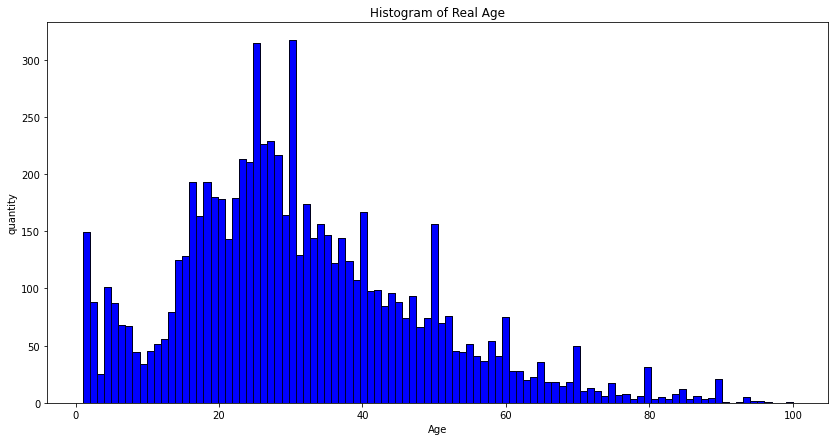

In [30]:
fig = plt.figure(figsize=(14,7))
plt.hist(labels['real_age'], color = 'blue', edgecolor = 'black',
         bins = 100)

# seaborn histogram
sns.distplot(labels['real_age'], hist=True, kde=False, 
             bins=100, color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Real Age')
plt.xlabel('Age')
plt.ylabel('quantity');

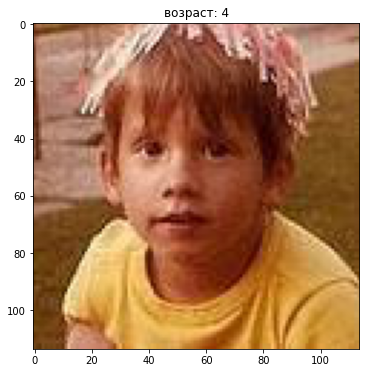

4


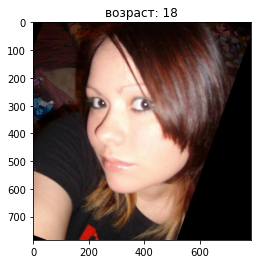

18


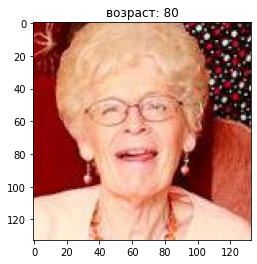

80


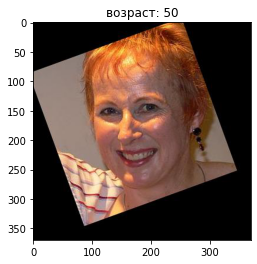

50


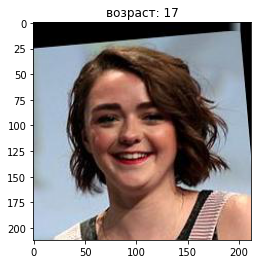

17


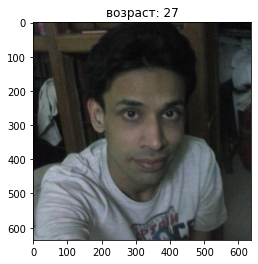

27


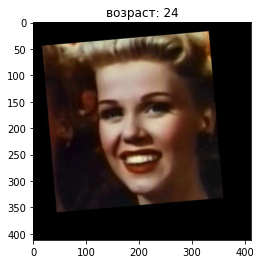

24


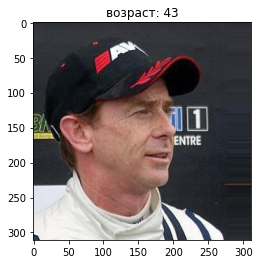

43


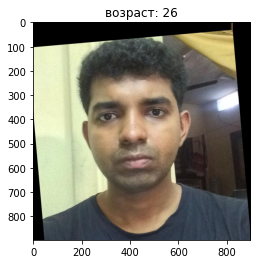

26


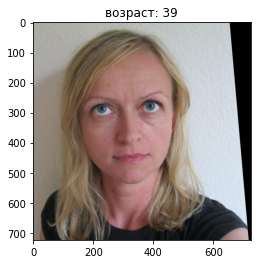

39


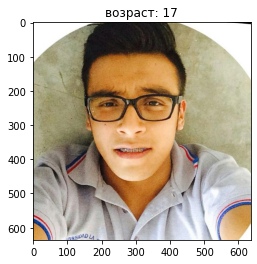

17


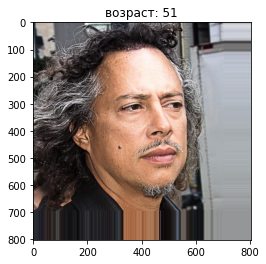

51


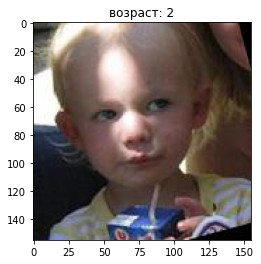

2


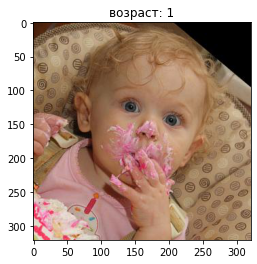

1


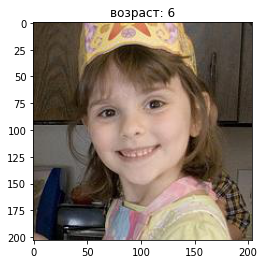

6


In [33]:
fig = plt.figure(figsize=(6,6))
for i in range(15):
    img = labels.file_name[i]
    age = labels.real_age[i]
    image = Image.open('/datasets/faces/final_files/'+img)
    plt.title('возраст: ' + str(age))
    plt.imshow(image)
    plt.show()
    print(labels.real_age[i])

__Комментарии__ Нам дана папка с изображениями, в котрой две колонки с изображением и возрастом, соответсвенно 7591 изображений типа объект, а также числового типа возраст. Максимальный возраст 100 лет, минимальный возраст 1 год, средний возраст 31 год изображений людей на фотографиях. Также видно, что по умолчанию модель ожидает входные изображения размером 224 x 224 пикселей с 3 каналами (цвет). По гистограмме возраста, мы видим количество изображений иммет всплеск от 22 до 30 лет. В промежутке каждых 10 лет мы видим небольшой всплеск юбилейных лет, видимо в день рождение юбилея фотографий становится больше. На фотографиях изображены люди разных возрастов, по одному человеку на одну фотографию, много снимков селфи в реальном формате, но есть и фоторграфии какбуд-то не из реальных, а снятые и скаченные из интернета, что будет усложнять обучение модели. Фотографии цветные RGB, но встречаются и черно-белые. Качество фотографий не очень хорошее, встречаются размытые кадры.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd


def load_train(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    train_datagen = ImageDataGenerator(
                        rescale = 1. / 255,
                        validation_split = 0.2,
						horizontal_flip = True
                        )

    train_gen_flow = train_datagen.flow_from_dataframe(
                        dataframe = df,
                        directory = '/datasets/faces/final_files/',
                        x_col = 'file_name',
                        y_col = 'real_age',
                        target_size = (224, 224),
                        batch_size = 34,
                        class_mode = 'raw',
                        subset = 'training',
                        seed = 12345
                        )

    return train_gen_flow


def load_test(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    valid_datagen = ImageDataGenerator(
                        rescale = 1. / 255, 
                        validation_split = 0.2
                        )

    validation_gen_flow = valid_datagen.flow_from_dataframe(
                        dataframe = df,
                        directory = '/datasets/faces/final_files/',
                        x_col = 'file_name',
                        y_col = 'real_age',
                        target_size = (224, 224),
                        batch_size = 35,
                        class_mode = 'raw',
                        subset = 'validation',
                        seed = 12345
                        )

    return validation_gen_flow
    

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.00002)
    model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=6,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data = test_data,
              batch_size = batch_size, 
              epochs = epochs,
              steps_per_epoch = steps_per_epoch,
              validation_steps = validation_steps,
              verbose = 2
              )

    return model

```

```

Train for 179 steps, validate for 44 steps
Epoch 1/6
2023-03-22 12:56:13.121784: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-22 12:56:13.539012: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
179/179 - 63s - loss: 635.3126 - mae: 19.9408 - val_loss: 809.9177 - val_mae: 23.4595
Epoch 2/6
179/179 - 40s - loss: 112.3797 - mae: 7.8461 - val_loss: 836.6982 - val_mae: 23.9304
Epoch 3/6
179/179 - 40s - loss: 63.6072 - mae: 6.0358 - val_loss: 657.3074 - val_mae: 20.5828
Epoch 4/6
179/179 - 41s - loss: 43.6959 - mae: 5.0573 - val_loss: 173.3351 - val_mae: 9.8496
Epoch 5/6
179/179 - 41s - loss: 31.1998 - mae: 4.2859 - val_loss: 100.9461 - val_mae: 7.8436
Epoch 6/6
179/179 - 38s - loss: 25.6357 - mae: 3.8502 - val_loss: 96.2868 - val_mae: 7.6788
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
44/44 - 8s - loss: 96.2868 - mae: 7.6788
Test MAE: 7.6788

```

## Анализ обученной модели

Мы построили и обучили свёрточную нейронную сеть на датасете с фотографиями людей. Добились значения MAE на тестовой выборке 7.
При обучении модели воспользовались архитектурой ResNet50 с оптимизатором adam при шаге lr=0.00002, в конце архитекруры не добавляли два слоя в верхушке, сконтруировали ее заново. Применили аугментацию на обучающей выборке отражение по горизонтали, значение MAE составила 7,6, модель обучилась  на 6 эпохах. 